<a href="https://colab.research.google.com/github/DaiVo20/za_traffic_detection/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Class descriptions:
idx2sign = {
    1: "No entry", # Cấm ngược chiều
    2: "No parking / waiting", # Cấm dừng và đỗ
    3: "No turning", # Cấm rẽ
    4: "Max Speed", # Giới hạn tốc độ
    5: "Other prohibition signs", # Cấm còn lại
    6: "Warning", # Nguy hiểm
    7: "Mandatory" # Hiệu lệnh
}

PATH = "drive/MyDrive/TrafficSign/data/za_traffic_2020"
TRAIN_PATH = os.path.join(PATH, "traffic_train")
json_path = os.path.join(TRAIN_PATH, "train_traffic_sign_dataset.json")
csv_path = os.path.join(TRAIN_PATH, "train.csv")

In [6]:
sign2idx = {}
for k, v in idx2sign.items():
  sign2idx[v] = k

In [7]:
sign2idx

{'Mandatory': 7,
 'Max Speed': 4,
 'No entry': 1,
 'No parking / waiting': 2,
 'No turning': 3,
 'Other prohibition signs': 5,
 'Warning': 6}

In [ ]:
with open(csv_path, "w") as csv_file:
  csv_file.write("file_name,xmin,ymin,xmax,ymax,class,label\n")
  with open(json_path) as json_file:
    data = json.load(json_file)
    annotations = data['annotations']
    for p in annotations:
      # print(p)
      # print('Bbox: ',p['bbox'])
      # print('Image: ',p['image_id'])
      # print('category_id: ',idx2sign[p['category_id']])
      csv_file.write("{}/{}.png,{},{},{},{},{},{}\n".format(os.path.join(TRAIN_PATH, "images"),p['image_id'], 
                                                         p['bbox'][0], p['bbox'][1],
                                                         p['bbox'][0]+p['bbox'][2], 
                                                         p['bbox'][1]+p['bbox'][3],
                                                         idx2sign[p['category_id']],
                                                         p['category_id']))

In [8]:
df = pd.read_csv(csv_path)
df.head()

,file_name,xmin,ymin,xmax,ymax,class,label
0,drive/MyDrive/TrafficSign/data/za_traffic_2020...,880,333,899,351,No parking / waiting,2
1,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1069,355,1152,438,No turning,3
2,drive/MyDrive/TrafficSign/data/za_traffic_2020...,768,480,777,487,No parking / waiting,2
3,drive/MyDrive/TrafficSign/data/za_traffic_2020...,781,337,798,352,Warning,6
4,drive/MyDrive/TrafficSign/data/za_traffic_2020...,733,352,740,360,No parking / waiting,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  11000 non-null  object
 1   xmin       11000 non-null  int64 
 2   ymin       11000 non-null  int64 
 3   xmax       11000 non-null  int64 
 4   ymax       11000 non-null  int64 
 5   class      11000 non-null  object
 6   label      11000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 601.7+ KB


In [10]:
df.file_name.nunique()

4500

In [11]:
from PIL import Image, ImageDraw
from matplotlib import patches
import cv2

In [12]:
def plot_image_examples(df, rows=2, cols=2, title='Image examples'):
  fig, axs = plt.subplots(rows, cols, figsize=(20,10))
  for row in range(rows):
    for col in range(cols):
      idx = np.random.randint(len(df), size=1)[0]
      img = Image.open(df.loc[idx, 'file_name'])
      axs[row, col].imshow(img)
      data = df[df['file_name']==df.loc[idx, 'file_name']]
      # print(data)
      for i in data.index:
        # print(i)
        # rect = cv2.rectangle(img, (df.loc[i,'xmin'], df.loc[i, 'ymin']), 
        #                      (df.loc[i,'xmax'], df.loc[i, 'ymax']),
        #                      color = (255, 0, 0), thickness = 2)

        rect = patches.Rectangle((df.loc[i,'xmin'], df.loc[i, 'ymin']), 
                                 df.loc[i, 'xmax']-df.loc[i, 'xmin'], 
                                 df.loc[i, 'ymax']-df.loc[i, 'ymin'],
                                 linewidth=1,edgecolor='r',facecolor='none')
        axs[row, col].add_patch(rect)
        axs[row, col].text(df.loc[i,'xmin'], df.loc[i, 'ymin'], df.loc[i, 'class'],
                           bbox={"alpha": 0.4},
                           clip_box=axs[row, col].clipbox, clip_on=True)

      axs[row, col].axis('off')

  plt.suptitle(title)

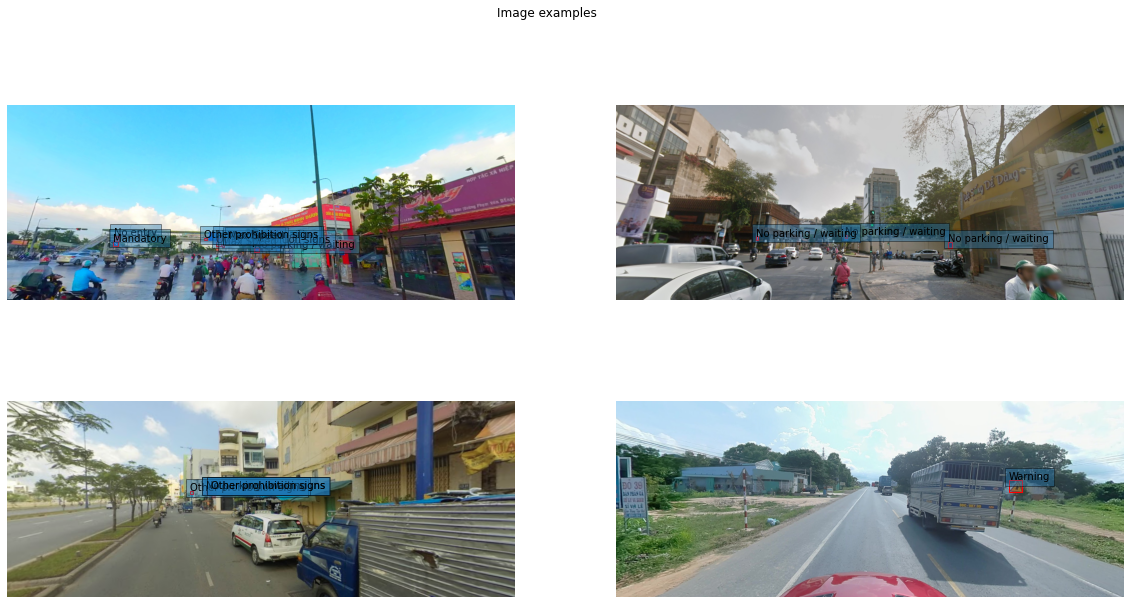

In [13]:
plot_image_examples(df)

No parking / waiting


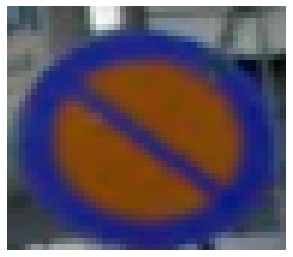

No turning


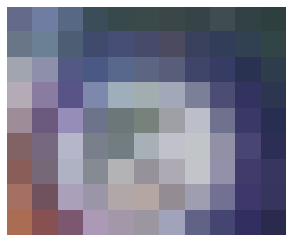

No parking / waiting


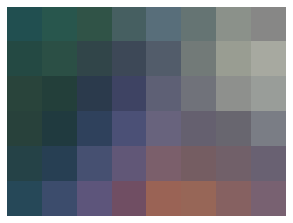

Other prohibition signs


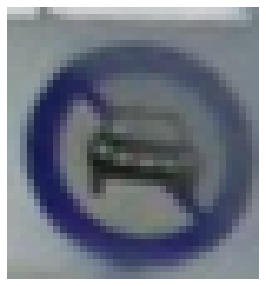

In [88]:
import cv2
from google.colab.patches import cv2_imshow
idx=9
img = Image.open(df.loc[idx, 'file_name'])
copy = image.copy()

df_img = df.loc[df['file_name'] == df.loc[idx, 'file_name'],:]
n_label = len(df_img)

ROI_number = 0
for c in df_img.index:
    print(df.loc[c,'class'])
    ROI = image[df.loc[c,'ymin']:df.loc[c,'ymax'], df.loc[c,'xmin']:df.loc[c,'xmax']]
    plt.figure(figsize=(5,5))
    plt.imshow(ROI)
    plt.axis('off')
    plt.show()
    # cv2.imwrite('data/ROI_{}.png'.format(ROI_number), ROI)
    cv2.rectangle(copy,(df.loc[c,'xmin'],df.loc[c,'ymin']),
                  (df.loc[c,'xmax'],df.loc[c,'ymax']),(36,255,12),2)
    ROI_number += 1

223 258 797 825
48 177 1567 1621


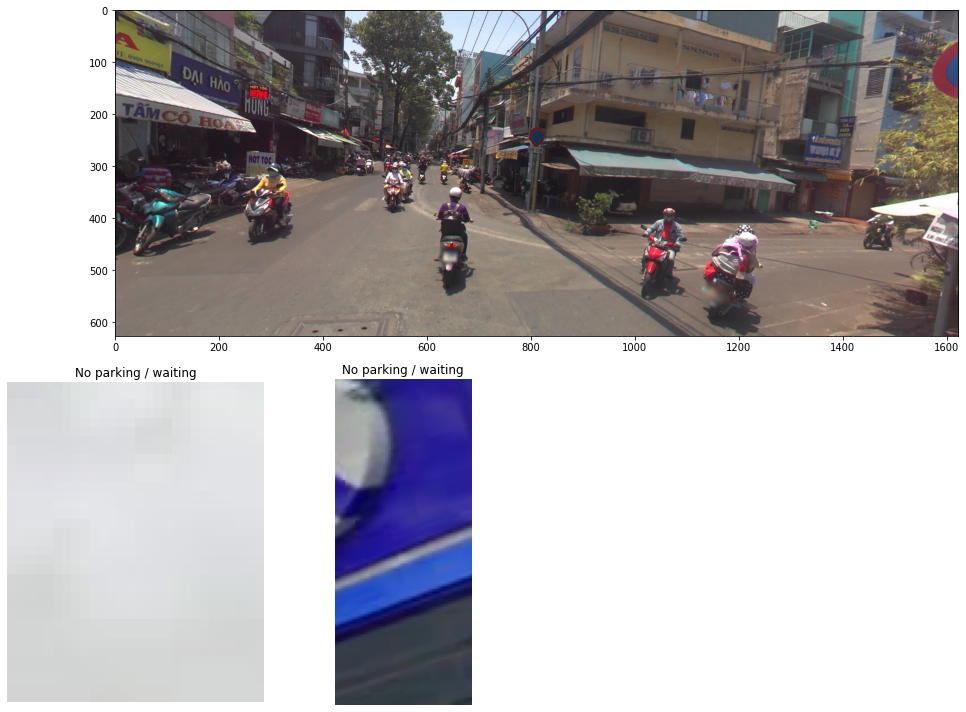

In [91]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

idx = np.random.randint(len(df), size=1)[0]
img = Image.open(df.loc[idx, 'file_name'])
df_img = df.loc[df['file_name'] == df.loc[idx, 'file_name'],:]
df_img

n_label = len(df_img)
if n_label%4==0:
  rows = n_label//4
else:
  rows = n_label//4 + 1

fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(rows+1, 4)

ax = fig.add_subplot(gs[0, :])
ax.imshow(img)
# ax.axis("off")

r, c = 1, 0
for i in df_img.index:
  ax1 = fig.add_subplot(gs[r, c])
  ROI = image[df.loc[i,'ymin']:df.loc[i,'ymax'], df.loc[i,'xmin']:df.loc[i,'xmax']]
  # ROI = image[2*df.loc[i,'ymin']-df.loc[i,'ymax']:df.loc[i,'ymin'], df.loc[i,'xmin']:df.loc[i,'xmax']]
  print(df.loc[i,'ymin'],df.loc[i,'ymax'], df.loc[i,'xmin'],df.loc[i,'xmax'])
  # ROI_cv = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
  ax1.set_title(df.loc[i,'class'])
  ax1.imshow(ROI)
  ax1.axis("off")
  cv2.imwrite('data/ROI_{}.png'.format(ROI_number), ROI)
  c+=1
  if c > 3:
    c=0
    r+=1

# ROI_number = 0
# for c in df_img.index:
#     print(df.loc[c,'class'])
#     ROI = image[df.loc[c,'ymin']:df.loc[c,'ymax'], df.loc[c,'xmin']:df.loc[c,'xmax']]
#     plt.figure(figsize=(5,5))
#     plt.imshow(ROI)
#     plt.axis('off')
#     # cv2.imwrite('data/ROI_{}.png'.format(ROI_number), ROI)
#     cv2.rectangle(copy,(df.loc[c,'xmin'],df.loc[c,'ymin']),
#                   (df.loc[c,'xmax'],df.loc[c,'ymax']),(36,255,12),2)
#     ROI_number += 1

In [74]:
[df.loc[i,'ymin'],df.loc[i,'ymax']]

[267, 305]

In [73]:
[df.loc[i,'xmin'],df.loc[i,'xmax']]

[1070, 1120]